## Lab 10
Kacper Szot, Jakub Rękas
### Zadanie 1
Dane jest równie różniczkowe $$ \frac{du}{dx} = cos(\omega x)$$ dla $x\in\Omega$,
  
  gdzie $x, \omega, u \in \mathbb{R}$
  
  $\Omega = \{ x| -2\pi \le x \le 2\pi \}$ to dziedzina szukanego rozwiązania
  
  $u(\cdot)$ to poszukiwana funkcja
  Warunek początkowy $$ u(0)=0. $$

  Analityczne roziązanie równiania z warunkiem początkowym przybiera następującą postać: $$ u(x) = \frac{1}{\omega}sin(\omega x). $$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def exact_solution(x, w0):
    "Defines the analytical spectral bias problem"
    return (1/w0) * np.sin(w0 * x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(device)

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

1
0
cuda


In [ ]:
torch.manual_seed(123)

In [ ]:
# train the PINN
def train(pinn, w0, test_points, train_steps=50001,train_points=3000):
  x_boundary = torch.tensor(0.,device=device).view(-1,1).requires_grad_(True)#
  x_physics = torch.linspace(-2*np.pi,2*np.pi,train_points,device=device).view(-1,1).requires_grad_(True)#
  x_test = torch.linspace(-2*np.pi,2*np.pi,test_points,device=device).view(-1,1)
  u_exact = exact_solution(x_test.cpu(),w0)
  optimiser = torch.optim.Adam(pinn.to(device).parameters(),lr=0.001)
  losses = []
  for i in range(train_steps):
      optimiser.zero_grad()

      # compute boundary loss
      u = pinn(x_boundary)#
      loss1 = (torch.squeeze(u))**2

      # compute physics loss
      u = pinn(x_physics)#
      dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]#
      loss2 = torch.mean((dudx - torch.cos(x_physics*w0))**2)
      loss =loss1+loss2
      losses.append(loss.cpu().detach().numpy())

      # backpropagate joint loss, take optimiser step
      loss.backward()
      optimiser.step()

      #plot the result as training progresses
      if i % 10000 == 0:
          u = pinn(x_test).detach()
          plt.figure(figsize=(6,2.5))
          plt.plot(x_test.cpu()[:,0], u_exact[:,0], label="Exact solution", color="tab:grey")
          plt.plot(x_test.cpu()[:,0], u.cpu()[:,0], label="PINN solution", color="tab:green")
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()

  plt.title("loss function")
  plt.yscale("log")
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.plot(losses)
  plt.show()


(a) Przypadek $\omega=1$.
  
2 warstwy ukryte, 16 neuronów w każdej warstwe  
liczba punktów treningowych: 200  
liczba punktów testowych: 1000

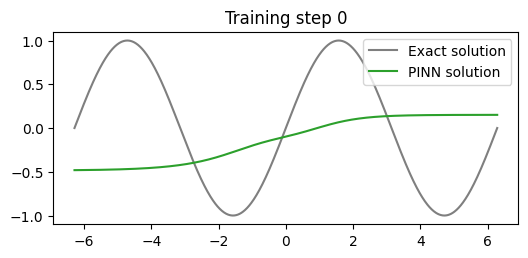

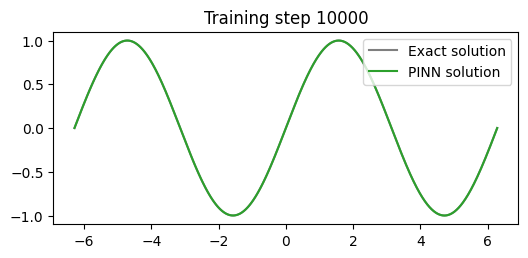

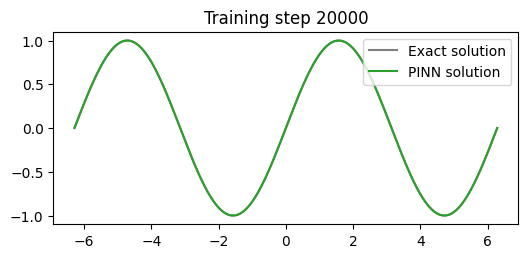

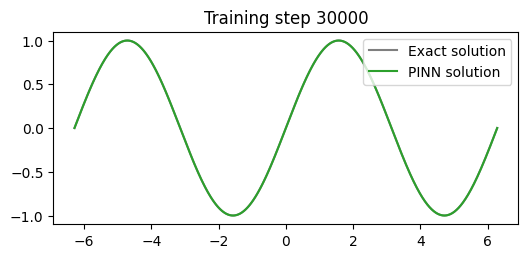

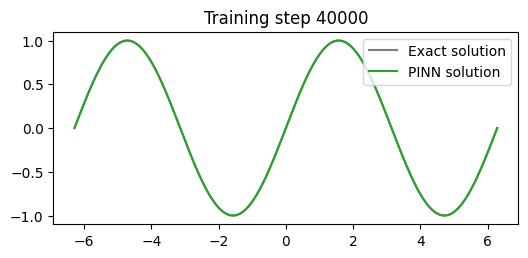

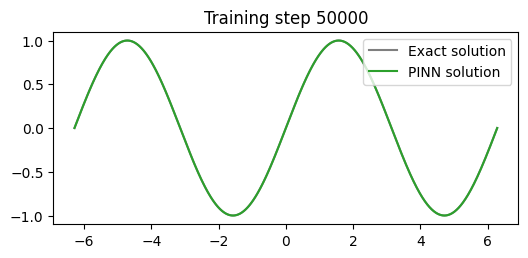

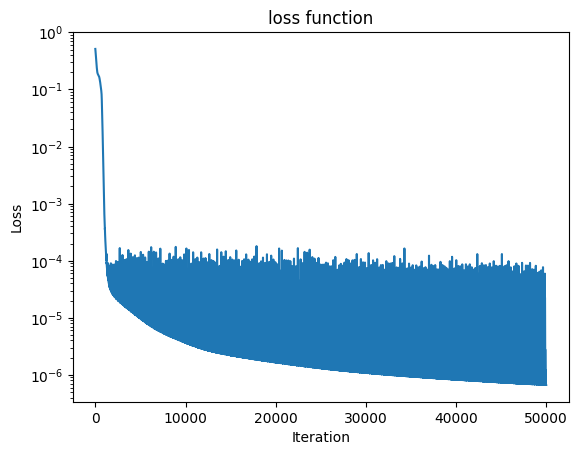

In [ ]:
#zadanie 1 model a
pinn = FCN(1,1,16,2)
train(pinn=pinn,w0=1,test_points=1000,train_points=200)

Sieć mimo małych rozmiarów, realatywnie szybko osiąga zbierznośc i dobre wyniki.

(b) Przypadek $\omega = 15.$
2 warstwy ukryte, 16 neuronów w każdej warstwie  
liczba punktów treningowych: 3000  
liczba punktów testowych: 5000  

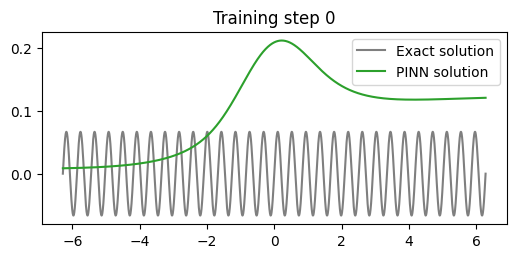

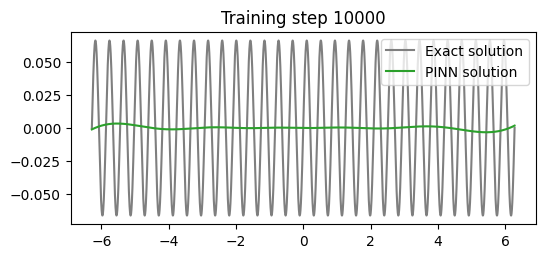

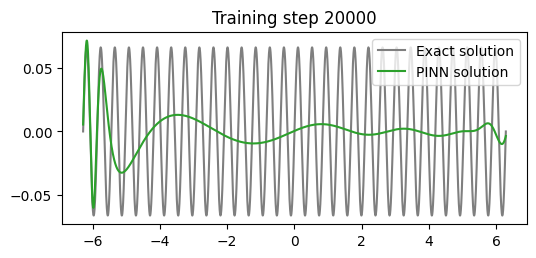

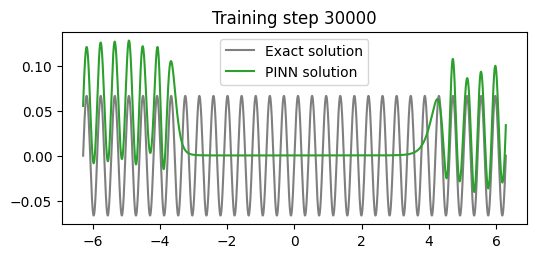

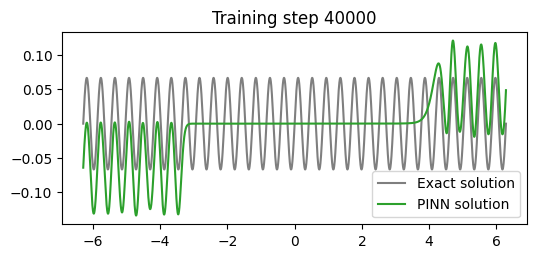

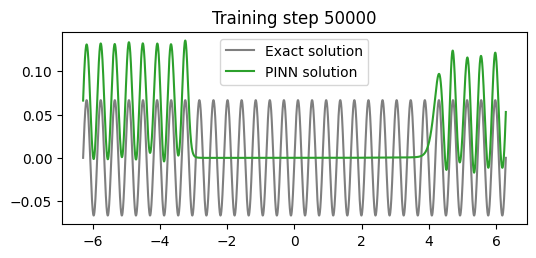

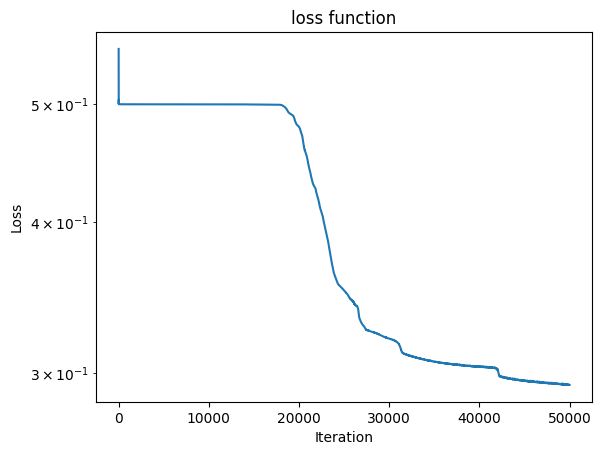

In [ ]:
#zadanie 1 podpunkt b model b
pinn = FCN(1,1,16,2)
train(pinn=pinn,w0=15,test_points=5000,train_points=3000)

Małej sieci neuronowej nie udaje się osiągnąć zadowalających wyników w trakcie 50000 iteracji dla wysokiej częstotliwości.

(b) Przypadek $\omega = 15.$
4 warstwy ukryte, 64 neuronów w każdej warstwie  
liczba punktów treningowych: 3000  
liczba punktów testowych: 5000  

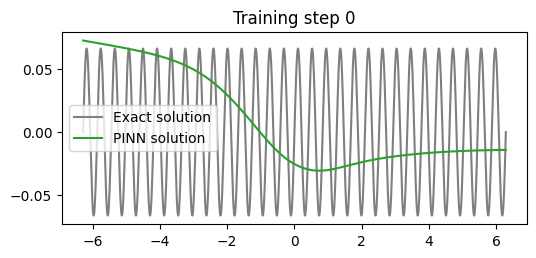

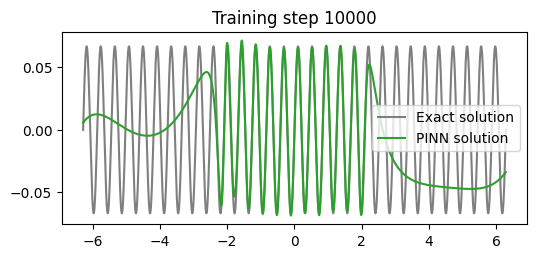

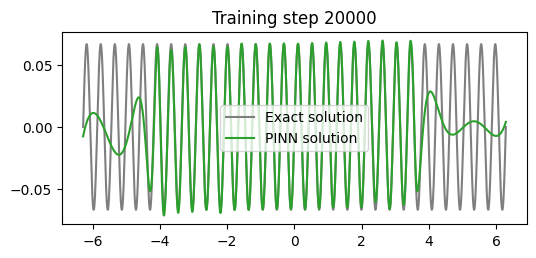

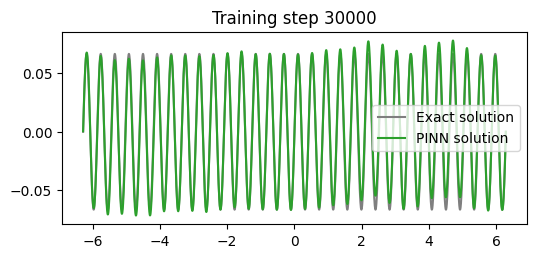

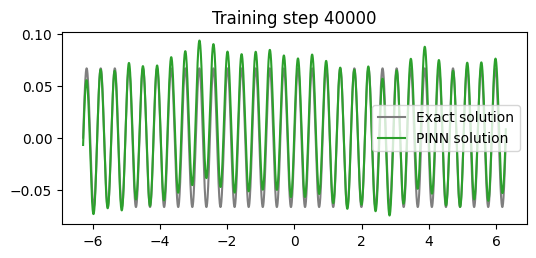

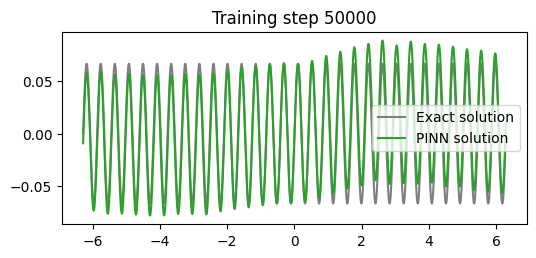

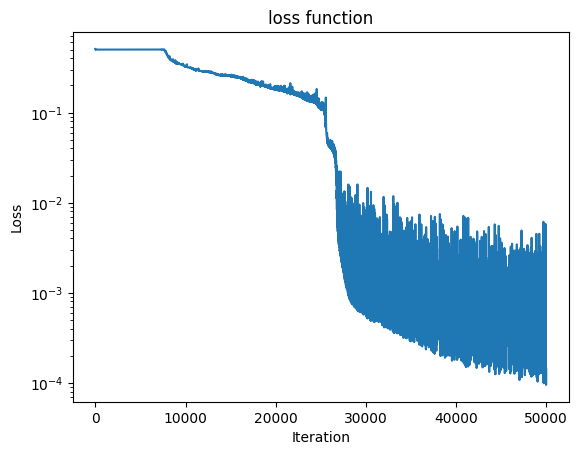

In [ ]:
#zadanie 1 podpunkt b model c
pinn = FCN(1,1,64,4)
train(pinn=pinn,w0=15,test_points=5000,train_points=3000)

Sieci neuronowej udaje się osiągnąć zadowalających wyników w trakcie 50000 iteracji dla wysokiej częstotliwości.



(b) Przypadek $\omega = 15.$
5 warstwy ukryte, 128 neuronów w każdej warstwie  
liczba punktów treningowych: 3000  
liczba punktów testowych: 5000  

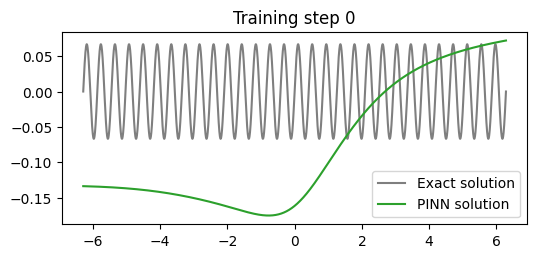

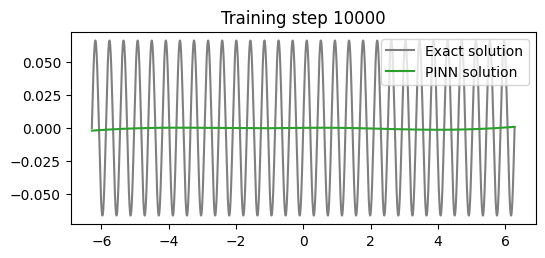

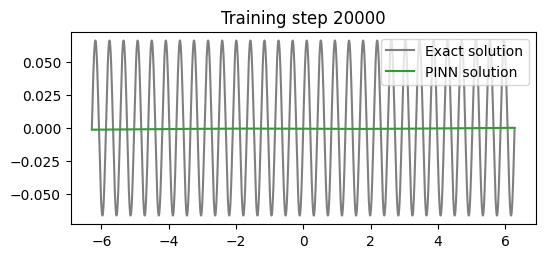

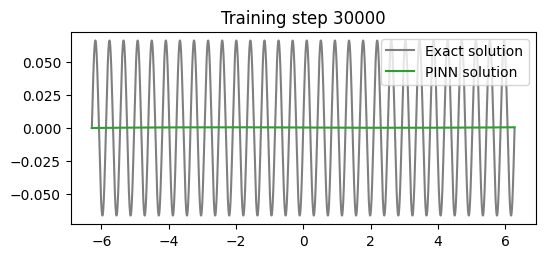

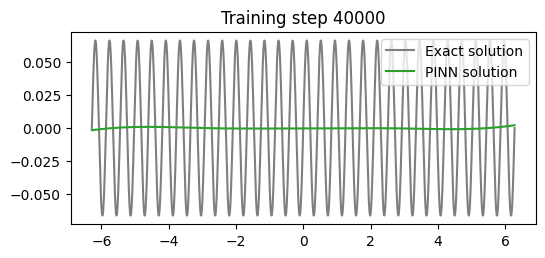

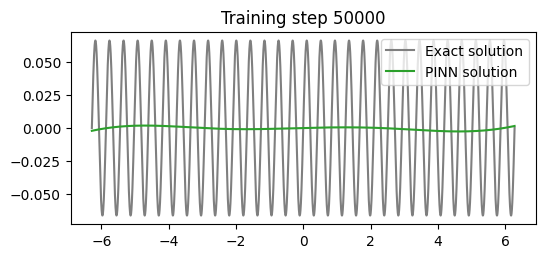

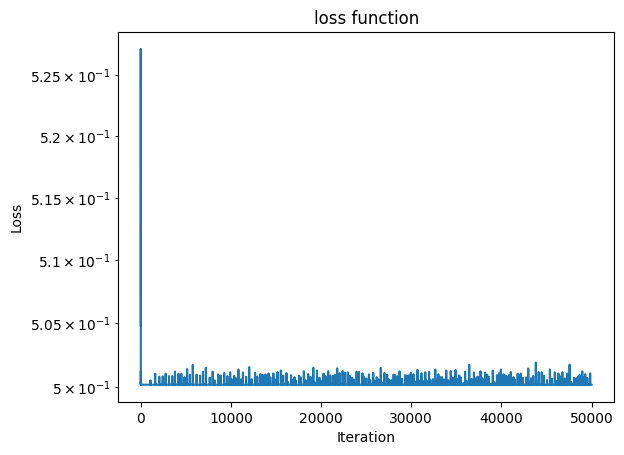

In [ ]:
#zadanie 1 podpunkt b model c
pinn = FCN(1,1,128,5)
train(pinn=pinn,w0=15,test_points=5000,train_points=3000)

Dużej sieci neuronowej nie udaje się osiągnąć zadowalających wyników w trakcie 50000 iteracji dla wysokiej częstotliwości, prawdopodobnie 50000 to zbyt mało iteracji.

(c)
4 warstwy ukryte, 64 neuronów w każdej warstwie  
liczba punktów treningowych: 3000  
liczba punktów testowych: 5000  
Aby zagwarantować spełnienie warunku $\hat u(0)=0$ wprowadzamy $\hat u(x)=tanh(\omega x)\cdot NN(x)$

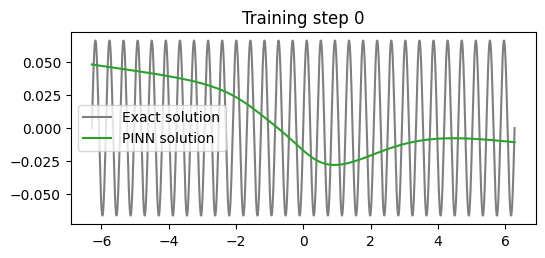

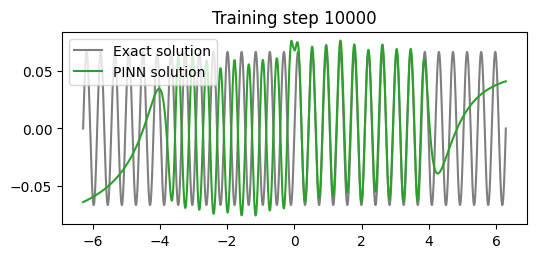

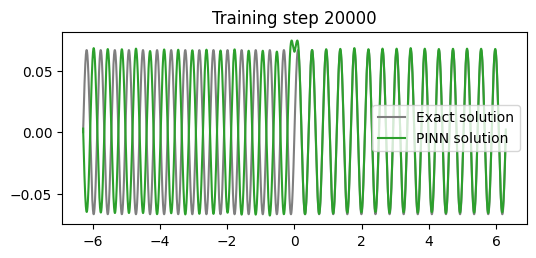

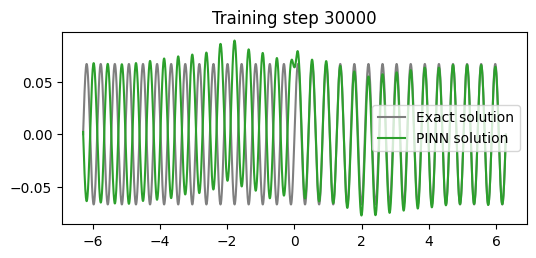

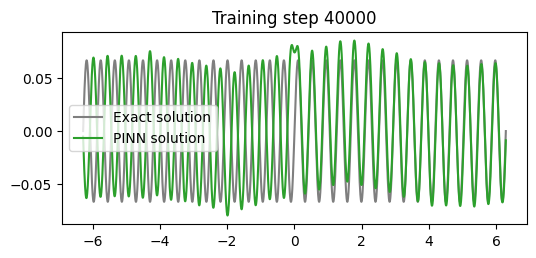

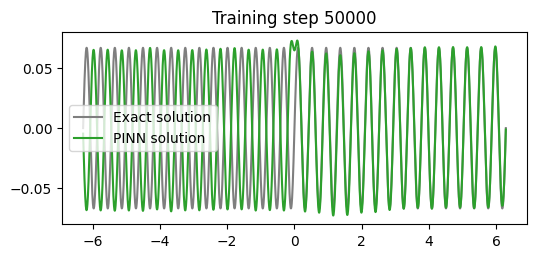

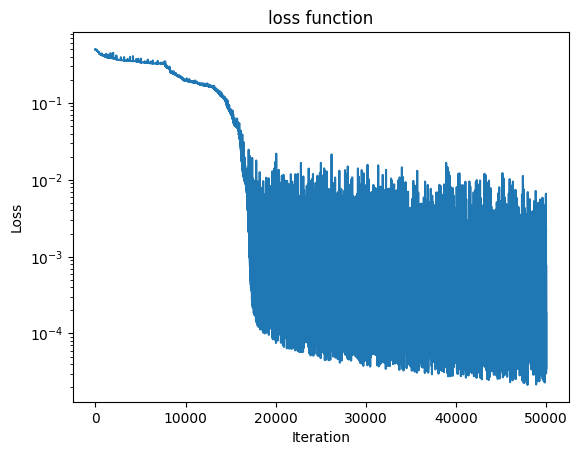

In [ ]:
# zadanie 1 podpunkt c
# zastoswoanie u = tanh(w0, x) * NN(x;0)
def train_using_tanh_in_output(pinn, w0, test_points, train_steps=50001,train_points=3000):
  x_boundary = torch.tensor(0.,device=device).view(-1,1).requires_grad_(True)#
  x_physics = torch.linspace(-2*np.pi,2*np.pi,train_points,device=device).view(-1,1).requires_grad_(True)#
  x_test = torch.linspace(-2*np.pi,2*np.pi,test_points,device=device).view(-1,1)
  u_exact = exact_solution(x_test.cpu(),w0)
  losses=[]
  optimiser = torch.optim.Adam(pinn.to(device).parameters(),lr=0.001)
  for i in range(train_steps):
      optimiser.zero_grad()
      # compute physics loss
      u = torch.tanh(x_physics*w0) * pinn(x_physics)#
      dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]#
      loss2 = torch.mean((dudx - torch.cos(x_physics*w0))**2)
      loss =loss2
      losses.append(loss.cpu().detach().numpy())


      # backpropagate joint loss, take optimiser step
      loss.backward()
      optimiser.step()

      #plot the result as training progresses
      if i % 10000 == 0:
          u = pinn(x_test).detach()
          plt.figure(figsize=(6,2.5))
          plt.plot(x_test.cpu()[:,0], u_exact[:,0], label="Exact solution", color="tab:grey")
          plt.plot(x_test.cpu()[:,0], u.cpu()[:,0], label="PINN solution", color="tab:green")
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()
  plt.title("loss function")
  plt.yscale("log")
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.plot(losses)
  plt.show()

pinn = FCN(1,1,64,4)
train_using_tanh_in_output(pinn=pinn,w0=15,test_points=5000,train_points=3000)

Po 50000 iteracjach można zauważyć, że  sieć osiągneła zbieżność dla $ x\ge 0$ natomiast nie dla $ x \lt 0$, gdyż tanh jest ujemny dla takich x, w celu naprawieniu tego problemu ustalmy $\hat u(x)=|tanh(\omega x)|\cdot NN(x)$

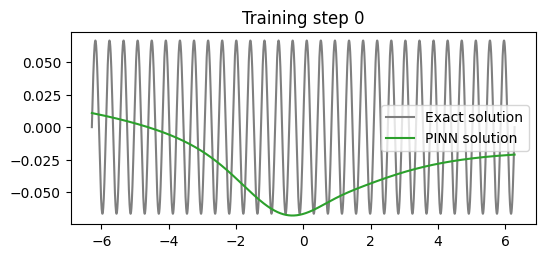

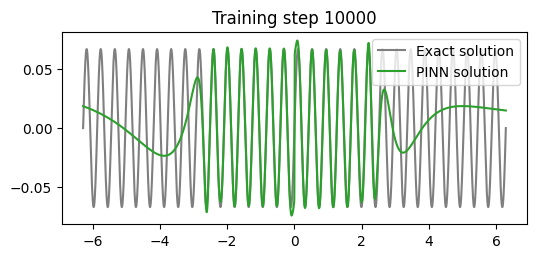

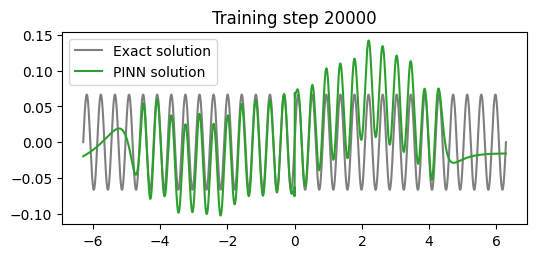

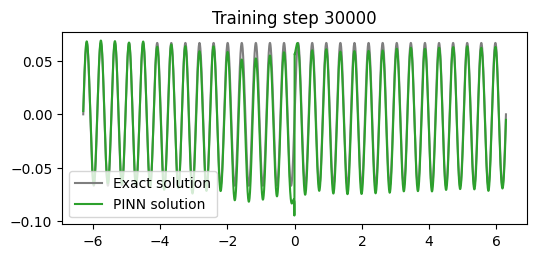

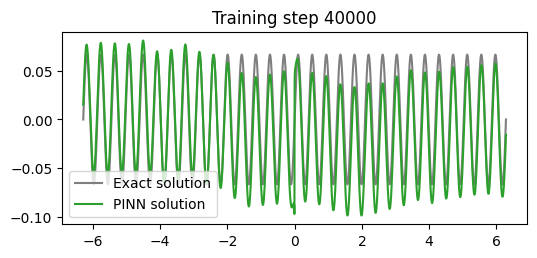

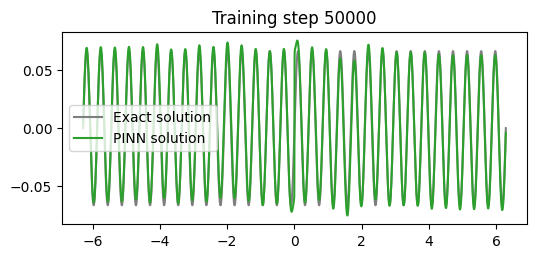

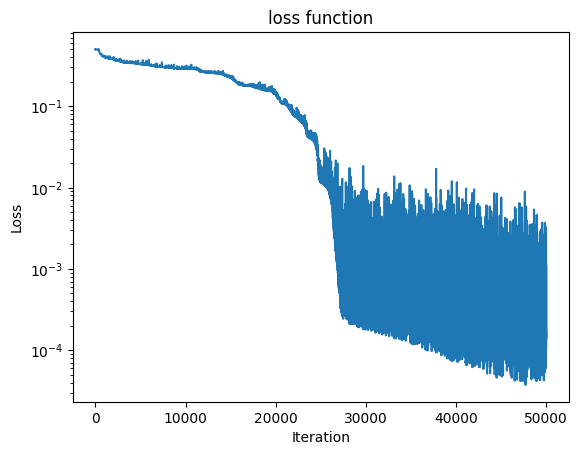

In [ ]:
# zadanie 1 podpunkt c
# zastoswoanie u = |tanh(w0, x)| * NN(x;0)
def train_using_absolute_tanh_in_output(pinn, w0, test_points, train_steps=50001,train_points=3000):
  x_boundary = torch.tensor(0.,device=device).view(-1,1).requires_grad_(True)#
  x_physics = torch.linspace(-2*np.pi,2*np.pi,train_points,device=device).view(-1,1).requires_grad_(True)#
  x_test = torch.linspace(-2*np.pi,2*np.pi,test_points,device=device).view(-1,1)
  u_exact = exact_solution(x_test.cpu(),w0)
  optimiser = torch.optim.Adam(pinn.to(device).parameters(),lr=0.001)
  losses = []
  for i in range(train_steps):
      optimiser.zero_grad()
      # compute physics loss
      u = abs(torch.tanh(x_physics*w0)) * pinn(x_physics)#
      dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]#
      loss2 = torch.mean((dudx - torch.cos(x_physics*w0))**2)
      loss =loss2
      losses.append(loss.cpu().detach().numpy())
      # backpropagate joint loss, take optimiser step
      loss.backward()
      optimiser.step()

      #plot the result as training progresses
      if i % 10000 == 0:
          u = pinn(x_test).detach()
          plt.figure(figsize=(6,2.5))
          plt.plot(x_test.cpu()[:,0], u_exact[:,0], label="Exact solution", color="tab:grey")
          plt.plot(x_test.cpu()[:,0], u.cpu()[:,0], label="PINN solution", color="tab:green")
          plt.title(f"Training step {i}")
          plt.legend()
          plt.show()
  plt.title("loss function")
  plt.yscale("log")
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.plot(losses)
  plt.show()

pinn = FCN(1,1,64,4)
train_using_absolute_tanh_in_output(pinn=pinn,w0=15,test_points=5000,train_points=3000)

Tym razem sieć daje poprawną odpowiedz dla całej dziedziny.

(d) 4 warstwy ukryte, 64 neuronów w każdej warstwie  
liczba punktów treningowych: 3000  
liczba punktów testowych: 5000  
Wagi pierwszej warstwy ukrytej zostały zainicjalizowane cechami Fouriera

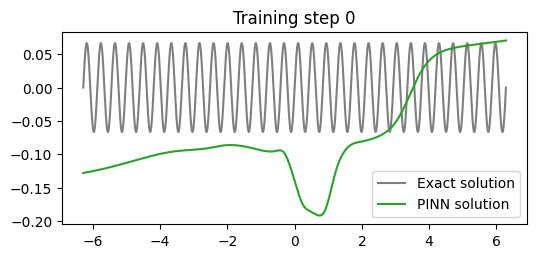

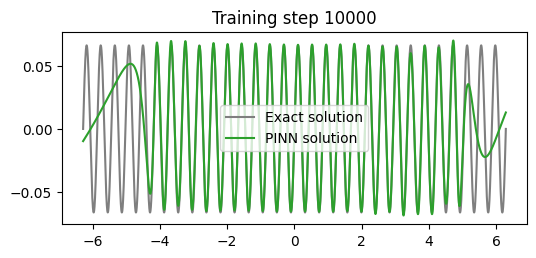

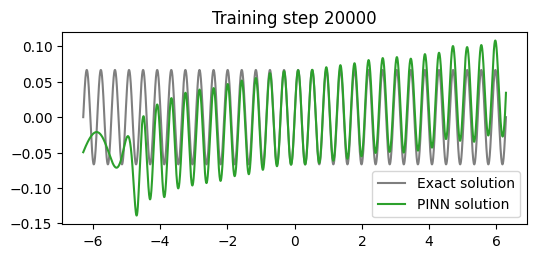

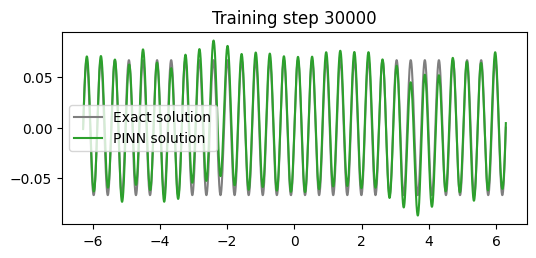

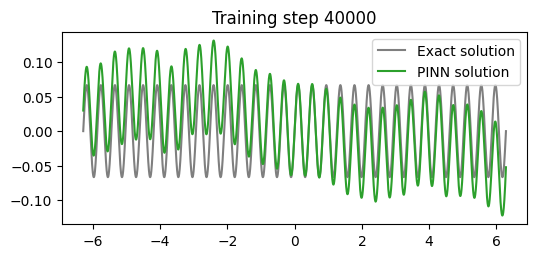

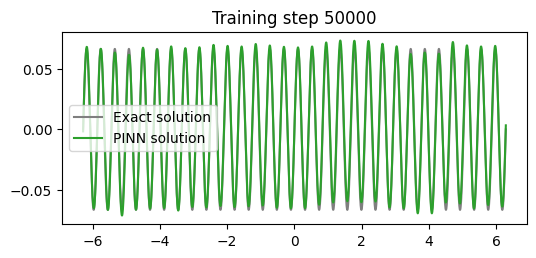

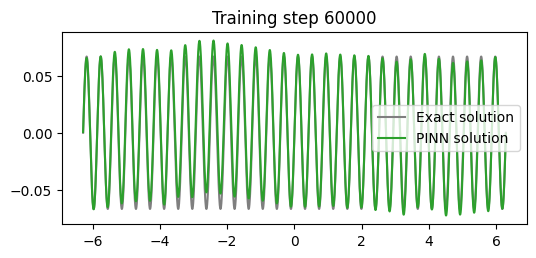

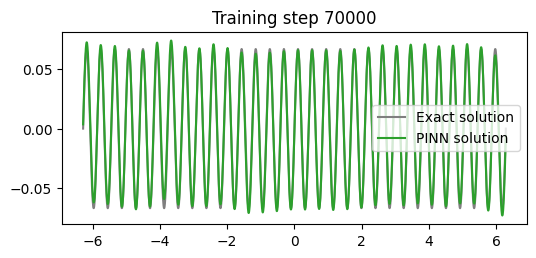

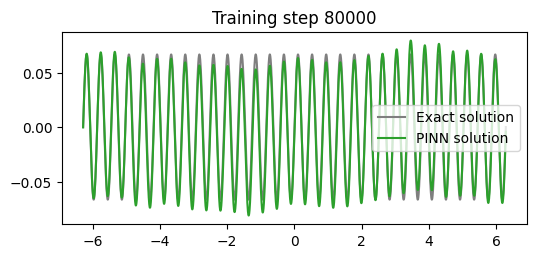

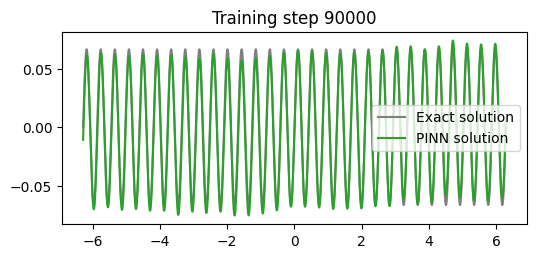

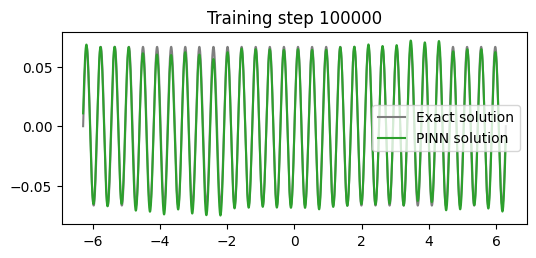

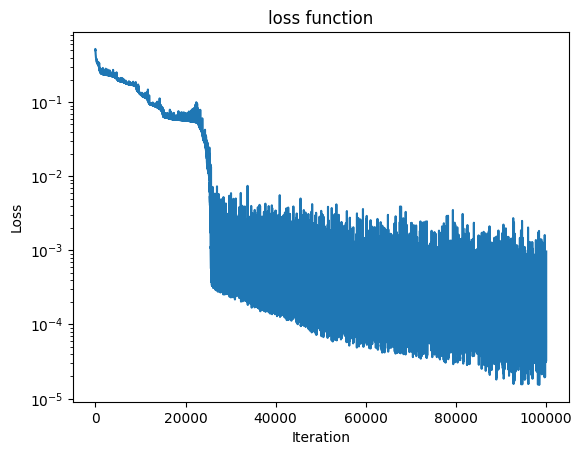

In [ ]:
# podpunkt d
from torch.nn import functional as F
class FourierLayer(nn.Linear):
    def __init__(self, N_INPUT, N_HIDDEN):
        super().__init__( N_INPUT, N_HIDDEN)
        self.N_INPUT = N_INPUT
        self.N_HIDDEN = N_HIDDEN
        self.weight = torch.nn.Parameter(self._initialize_weights())

    def _initialize_weights(self):
        weights = np.zeros((self.N_HIDDEN, self.N_INPUT))
        for i in range(self.N_HIDDEN):
            for j in range(self.N_INPUT):
                if j % 2 == 0:
                    weights[i, j] = np.sin(2 ** (j+i) * np.pi)
                else:
                    weights[i, j] = np.cos(2 ** (j+i) * np.pi)
        weights = torch.tensor(weights, dtype=torch.float32)
        return weights

class FCN_fourier_variant(nn.Module):
    "Defines a fully-connected network in PyTorch with Fourier-initialized first layer"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh


        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])

        # Pierwsza warstwa ukryta
        self.ffch = nn.Sequential(
            FourierLayer(N_HIDDEN, N_HIDDEN),
            activation()

        )


        # Warstwy ukryte dalesze
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS-2)
        ])

        # Warstwa końcowa
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.ffch(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
pinn = FCN_fourier_variant(1,1,64,4)
train(pinn=pinn,w0=15,test_points=5000,train_points=3000,train_steps=100001)

Sieć osiąga zadowalające wyniki już po 30000 iteeracji.

#### Wnioski
Bardzo małe sieci dają poprawne wyniki dla niskich wartości $\omega$, dla wyższych częstotliwości, nie udaje im się to.

Najlepszy stosunek wielkości do jakości wyników oferują sieci o 4 warstwach ukrytych i 64 neuronach na warstwe.